### Importing necessary libraries

In [25]:
import warnings
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
import datetime
warnings.filterwarnings('ignore')

FIRE_PATH = "./data/FIRE/"
ACC_PATH = "./data/ACCIDENT/"
ROB_PATH = "./data/ROBBERY/"
NORMAL_PATH = "./data/NORMAL/"

CLASSES = ["Normal", "Fire", "Accident", "Robbing"]

# Define the training and testing sets' split size
TRAIN_SPLIT = 0.74
TEST_SPLIT = 0.26

# Initialize the model parameters (learning rate, batch size, and number of epochs)
INIT_LR = 1e-2
BATCH_SIZE = 64

### Data Collection and Preprocessing

In [26]:
def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory, then
    # initialize our lists of images
    imagePaths = list(paths.list_images(datasetPath))
    data = []
    # loop over the image paths
    for imagePath in imagePaths:
        # load the image and resize it to be a fixed 128x128 pixels,
        # ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (128, 128))
        # add the image to the data lists
        data.append(image)
        # return the data list as a NumPy array
    return np.array(data, dtype="float32")

print("[INFO] loading normal data...")
normalData = load_dataset(NORMAL_PATH)
np.random.shuffle(normalData)
normalData = normalData[:2666]
print("[INFO] loading fire data...")
fireData = load_dataset(FIRE_PATH)
print("[INFO] loading accident data...")
accidentData = load_dataset(ACC_PATH)
print("[INFO] loading robbery data...")
robberyData = load_dataset(ROB_PATH)

[INFO] loading normal data...
[INFO] loading fire data...
[INFO] loading accident data...
[INFO] loading robbery data...


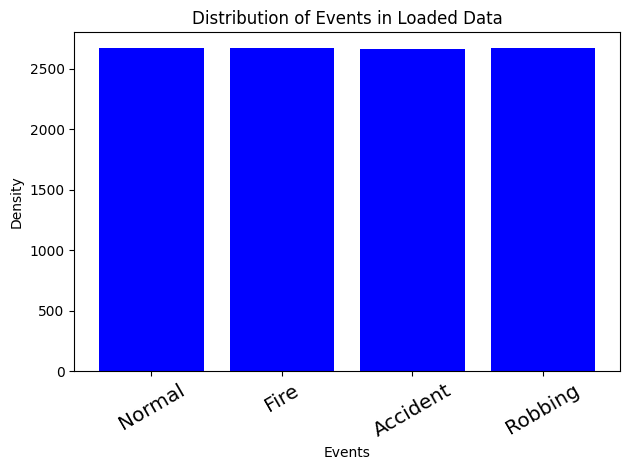

<Figure size 640x480 with 0 Axes>

In [27]:
label = CLASSES
file_count = [normalData.shape[0],fireData.shape[0],accidentData.shape[0],robberyData.shape[0]]
index = np.arange(len(label))
plt.bar(index, file_count, color="blue")
plt.xlabel('Events')
plt.ylabel('Density')
plt.xticks(index, label, rotation=30, fontsize='x-large')
plt.title('Distribution of Events in Loaded Data')
plt.tight_layout()
plt.savefig('train_test_data_distribution.png', format='png', dpi=1000)
# plt.style.use("ggplot")
plt.figure()
plt.show()

In [28]:
normalData.shape, fireData.shape, accidentData.shape, robberyData.shape

((2666, 128, 128, 3),
 (2666, 128, 128, 3),
 (2665, 128, 128, 3),
 (2666, 128, 128, 3))

### Exploratory Data Analysis

[INFO] Label created for all data...
[INFO] stacking data...


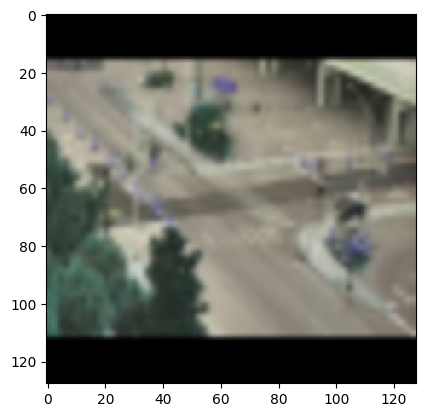

In [29]:
# construct the class labels for the data
normalLabels = np.zeros((normalData.shape[0],))
fireLabels = np.ones((fireData.shape[0], ))
accidentLabels = np.full(accidentData.shape[0],2)
robberyLabels = np.full(robberyData.shape[0],3)
print("[INFO] Label created for all data...")
labels = np.hstack([normalLabels, fireLabels, accidentLabels, robberyLabels])
labels = labels.astype(int)
# stack the fire data with the non-fire data
print("[INFO] stacking data...")
data = np.vstack([normalData, fireData, accidentData, robberyData])
data /= 255    #scale the data to the range [0, 1]
pic = data[1101]
plt.grid(False)
plt.imshow(pic)

In [30]:
data.shape

(10663, 128, 128, 3)

In [31]:
labels.shape

(10663,)

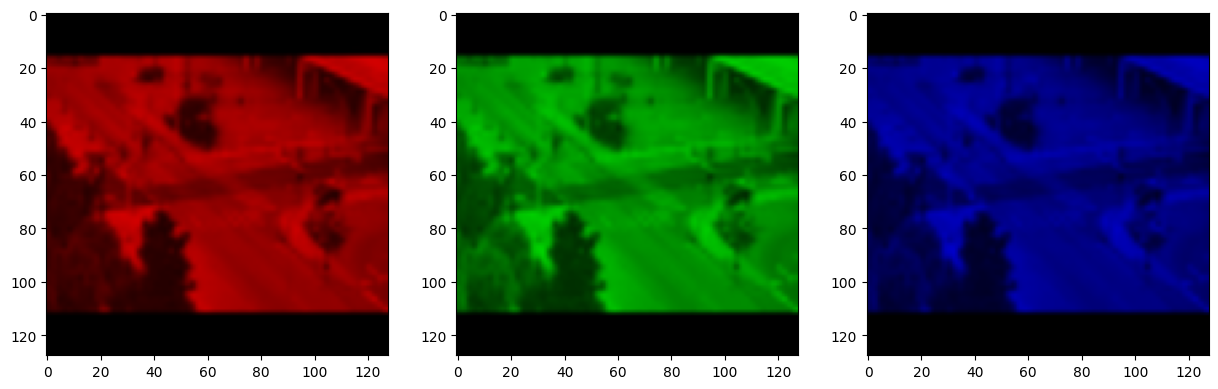

In [32]:
# display each channel
pic = data[1101]
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))
for c, ax in zip(range(3), ax):
    # create zero matrix
    split_img = np.zeros(pic.shape, dtype="float32") # 'dtype' by default: 'numpy.float64'
    # assing each channel
    split_img[ :, :, c] = pic[ :, :, c]
    ax.grid(False)
    # display each channel
    ax.imshow(split_img)
plt.show()

In [33]:
# perform one-hot encoding on the labels and account for skew in the labeled data
# labels = to_categorical(labels, num_classes=4)
classTotals = labels.sum(axis = 0)
classWeight = classTotals.max() / classTotals

### TRAIN - TEST SPLIT

In [34]:
# construct the training and testing split
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size = TEST_SPLIT, random_state = 42)

X_train.shape

(7890, 128, 128, 3)

In [35]:
y_train.shape

(7890,)

In [36]:
X_test.shape

(2773, 128, 128, 3)

In [37]:
y_test.shape

(2773,)

In [38]:
labels

array([0, 0, 0, ..., 3, 3, 3])

### Model Creation

In [39]:
width, height, depth, classes = 128, 128, 3, 4
# initialize the model along with the input shape to be
# "channels last" and the channels dimension itself
model = Sequential()
img_shape = (height, width, depth)
chanDim = -1
# CONV => RELU => POOL
model.add(SeparableConv2D(16, (7, 7), padding="same",input_shape=img_shape, activation="relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
# CONV => RELU => POOL
model.add(SeparableConv2D(32, (3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
# (CONV => RELU) * 2 => POOL
model.add(SeparableConv2D(64, (3, 3), padding="same",activation="relu"))
#model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(SeparableConv2D(64, (3, 3), padding="same",activation="relu"))
#model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# second set of FC => RELU layers
model.add(Dense(128, activation="relu"))
# model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))
# return the constructed network architecture


### Optimize the model parameters (weights and biases)

In [40]:
# initialize the optimizer and model
opt = SGD(learning_rate= INIT_LR, momentum = 0.95)
opt_2 = RMSprop()
model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"], run_eagerly=True)
print("[INFO] compiling model...")

[INFO] compiling model...


In [41]:
#Using callback to store the weights of the best model
checkpointer = ModelCheckpoint(filepath="./data/best_weights_act_DWS.keras",
                               monitor = 'val_accuracy',
                               verbose=1,
                               save_best_only=True)


NUM_EPOCHS = 150

# Model training
t_start = datetime.datetime.now()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=NUM_EPOCHS, callbacks=checkpointer)
t_end= datetime.datetime.now()
timeTaken = t_end - t_start
print("Time taken for training(s):", int(timeTaken.total_seconds()))


Epoch 1/150
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7308 - loss: 0.7894
Epoch 1: val_accuracy improved from -inf to 0.98197, saving model to ./data/best_weights_act_DWS.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 79s 313ms/step - accuracy: 0.7313 - loss: 0.7878 - val_accuracy: 0.9820 - val_loss: 0.0654
Epoch 2/150
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9652 - loss: 0.1020
Epoch 2: val_accuracy did not improve from 0.98197
247/247 ━━━━━━━━━━━━━━━━━━━━ 73s 295ms/step - accuracy: 0.9652 - loss: 0.1020 - val_accuracy: 0.9416 - val_loss: 0.1568
Epoch 3/150
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9832 - loss: 0.0614
Epoch 3: val_accuracy improved from 0.98197 to 0.99820, saving model to ./data/best_weights_act_DWS.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 75s 303ms/step - accuracy: 0.9832 - loss: 0.0614 - val_accuracy: 0.9982 - val_loss: 0.0047
Epoch 4/150
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9898 - loss: 0.0346
Epoch 4: val_accuracy di

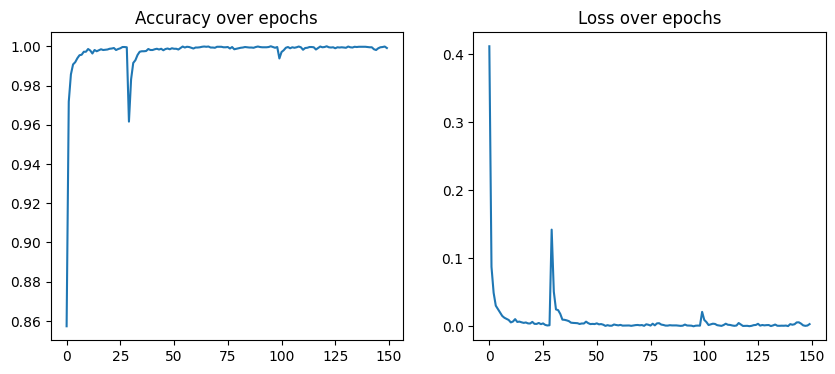

In [42]:
# Model Accuracy and loss plots over epochs

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history.history["accuracy"])
ax[0].set_title("Accuracy over epochs")

ax[1].plot(history.history["loss"])
ax[1].set_title("Loss over epochs")
plt.show()

In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_4              │ (None, 128, 128, 16)   │           211 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 64, 64, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 32, 32, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_7              │ (None, 32, 32, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           51

 Total params: 4,247,280 (16.20 MB)

 Trainable params: 2,123,207 (8.10 MB)

 Non-trainable params: 864 (3.38 KB)

 Optimizer params: 2,123,209 (8.10 MB)

### Save the model

In [44]:
model.save('./models/anomaly_detection.keras')

### Testing and Evaluation

In [45]:
loss,acc = model.evaluate(X_test, y_test, verbose = 1)
print(f'Accuracy of the model is %f' %(acc * 100))

# Evaluate the network and display the classification report
predictions = model.predict(X_test, batch_size = BATCH_SIZE)
print("Classification Report:")
print(classification_report(y_test, predictions.argmax(axis = 1), target_names = CLASSES))

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9994 - loss: 0.0042
Accuracy of the model is 99.891812
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       701
        Fire       1.00      1.00      1.00       698
    Accident       1.00      1.00      1.00       691
     Robbing       1.00      1.00      1.00       683

    accuracy                           1.00      2773
   macro avg       1.00      1.00      1.00      2773
weighted avg       1.00      1.00      1.00      2773



Text(0.5, 23.52222222222222, 'Predicted label')

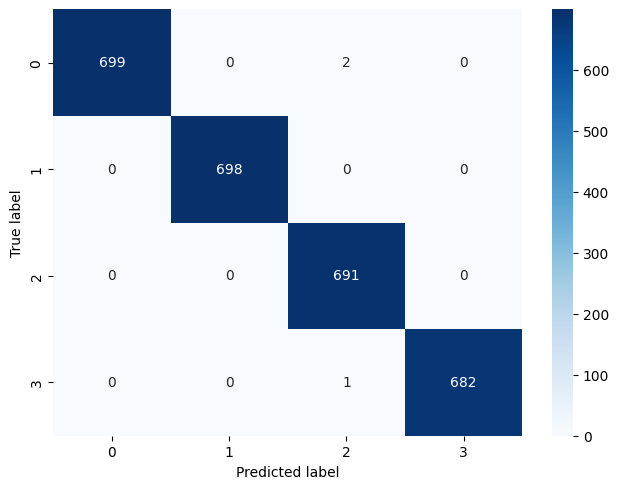

In [46]:
con_mat = confusion_matrix(y_test, predictions.argmax(axis = 1))
sns.heatmap(con_mat, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [50]:
model = load_model('./models/anomaly_detection.keras')


# Prediction from Video Input
def detect_anomaly(path):
    #Load video
    output_notebook()

    cap = cv2.VideoCapture(path)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    frame = cv2.flip(frame, 0) # because Bokeh flips vertically
    width = frame.shape[1]
    height = frame.shape[0]
    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=700, height=400)
    myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
    label = ""
    # show(p, notebook_handle = True)
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            img = frame
            img = cv2.resize(img,(128, 128),interpolation=cv2.INTER_AREA)
            img = img.astype("float32") / 255.0
            preds = model.predict(np.expand_dims(img, axis=0))[0]
            j = np.argmax(preds)
            label = CLASSES[j]
            cv2.putText(frame, label, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 5)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
            frame = cv2.flip(frame, 0)
            myImage.data_source.data['image'] = [frame]
            push_notebook()
            if cv2.waitKey(1) & 0xFF == ord('q'): # press q to quit
                break
        else:
            break
        #time.sleep(0.2)
    cap.release()
    print("Detected Activity: " + label)

detect_anomaly(input("path: "))

Loading BokehJS ...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━